In [39]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D , MaxPool2D, Flatten, Dense
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import Model
from matplotlib import pyplot
from sklearn.metrics import ConfusionMatrixDisplay
from numpy import expand_dims
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.vgg19 import VGG19
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from IPython.display import Image, display

In [31]:
train = image_dataset_from_directory(
    'data/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=1,
    image_size=(224, 224),
    shuffle=False,
    seed=42,
    validation_split=0.0
)

val = image_dataset_from_directory(
    'data/val/',
    labels='inferred',
    label_mode='categorical',
    batch_size=1,
    image_size=(224, 224),
    shuffle=False,
    seed=42,
    validation_split=0.0
)

test = image_dataset_from_directory(
    'data/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=1,
    image_size=(224, 224),
    shuffle=False,
    seed=42,
    validation_split=0.0
)
class_names = train.class_names

def normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image, label

train = train.map(normalize)
val = val.map(normalize)
test = test.map(normalize)

Found 250 files belonging to 5 classes.
Found 50 files belonging to 5 classes.
Found 100 files belonging to 5 classes.


In [32]:
vgg19 = VGG19() # trained on imagenet
vgg19_layers = vgg19.layers
keras.Input
model = Sequential()

for i in range(len(vgg19_layers)-1):
    model.add(vgg19_layers[i])
    
for i in range(len(vgg19_layers)):
    layers.trainable = False
    
model.add(Dense(5, activation = "softmax", name='fc3'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [7]:
# retrain the classification layer

# callbacks
my_callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=1),
    TensorBoard(log_dir=f'./logdir/Q2/')
]

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_fit = model.fit(train, validation_data = val, epochs = 100, callbacks = my_callbacks, verbose = 1)

Epoch 1/100
119/250 [=============>................] - ETA: 2:46 - loss: 72292.7969 - accuracy: 0.8908

KeyboardInterrupt: 

In [13]:
def get_image(image_path):
    # Load and decode image file
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Convert image to float32 tensor and normalize pixel values
    image = tf.cast(image, tf.float32) / 255.0

    # Reshape image tensor to match model input shape
    image = tf.image.resize(image, [224, 224])

    # Add batch dimension to image tensor
    image = tf.expand_dims(image, 0)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


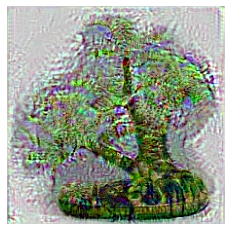

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


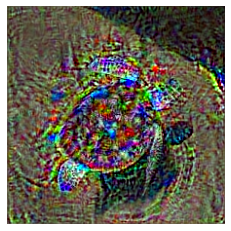

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


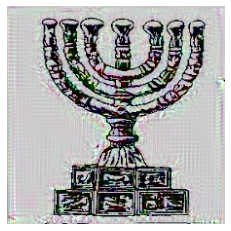

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


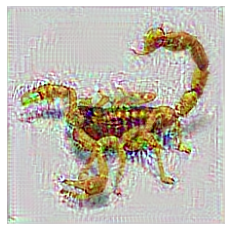

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


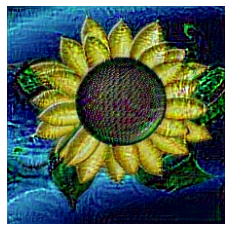

In [17]:
image_paths = ["Group_24/train/bonsai/image_0060.jpg","Group_24/train/hawksbill/image_0058.jpg","Group_24/train/menorah/image_0004.jpg","Group_24/train/scorpion/image_0005.jpg","Group_24/train/sunflower/image_0018.jpg"]

for path in image_paths:
    part_model = Model(inputs=model.inputs, outputs=model.layers[21].output)
    image = get_image(path)
    x = tf.constant(image)

    with tf.GradientTape() as tape:
        tape.watch(x)
        hidden_output = part_model(x)
        max_neuron_index = tf.math.argmax(hidden_output, axis=-1)
        neuron_output = tf.gather(hidden_output, max_neuron_index, axis=-1)


    # Calculate gradients with respect to every trainable variable
    grad = tape.gradient(neuron_output,x)
    # print(grad)
    alpha = 0.8
    masked_img = alpha * image[0] + (1 - alpha) * grad[0]
    plt.imshow(masked_img)
    plt.axis("off")
    plt.show()

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    last_conv_layer_output, preds = grad_model(img_array)
    heatmaps = []

    with tf.GradientTape(persistent = True) as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channels = [preds[:, pred_index] for pred_index in range(len(preds[0]))]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads_all = [tape.gradient(class_channels[i], last_conv_layer_output) for i in range(len(class_channels))]
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads_all = [tf.reduce_mean(grads_all[i], axis=(0, 1, 2)) for i in range(len(grads_all))]

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    for i in range(len(preds[0])):
        heatmap = last_conv_layer_output @ pooled_grads_all[i][..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmaps.append(heatmap.numpy())
    return heatmaps

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [33]:
model = tf.keras.models.load_model('./models/task_2/task2-vgg19.tf')

'heatmaps for bonsai class'

'with respect to neuron corresponding to class-"bonsai"'

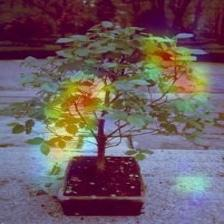

'with respect to neuron corresponding to class-"hawksbill"'

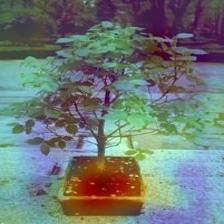

'with respect to neuron corresponding to class-"menorah"'

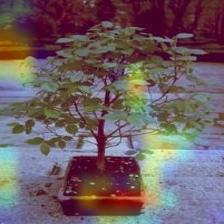

'with respect to neuron corresponding to class-"scorpion"'

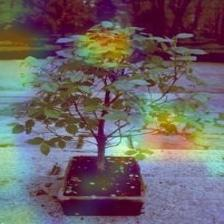

'with respect to neuron corresponding to class-"sunflower"'

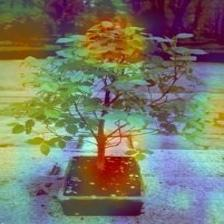

'heatmaps for hawksbill class'

'with respect to neuron corresponding to class-"bonsai"'

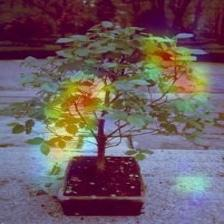

'with respect to neuron corresponding to class-"hawksbill"'

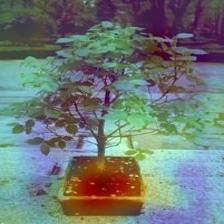

'with respect to neuron corresponding to class-"menorah"'

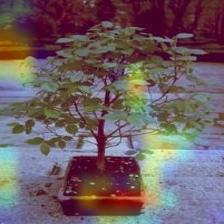

'with respect to neuron corresponding to class-"scorpion"'

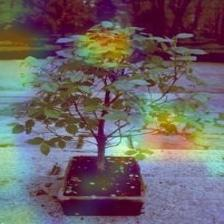

'with respect to neuron corresponding to class-"sunflower"'

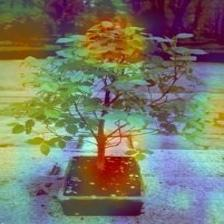

'heatmaps for menorah class'

'with respect to neuron corresponding to class-"bonsai"'

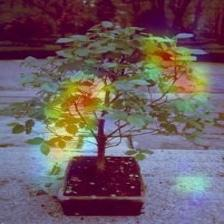

'with respect to neuron corresponding to class-"hawksbill"'

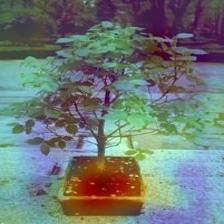

'with respect to neuron corresponding to class-"menorah"'

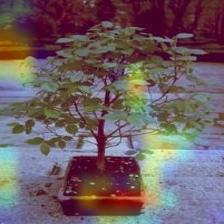

'with respect to neuron corresponding to class-"scorpion"'

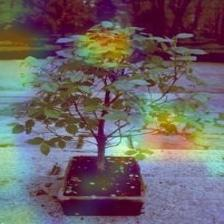

'with respect to neuron corresponding to class-"sunflower"'

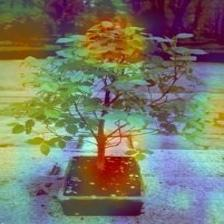

'heatmaps for scorpion class'

'with respect to neuron corresponding to class-"bonsai"'

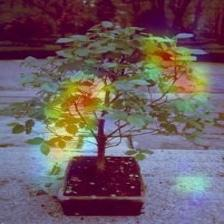

'with respect to neuron corresponding to class-"hawksbill"'

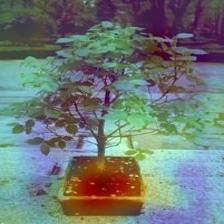

'with respect to neuron corresponding to class-"menorah"'

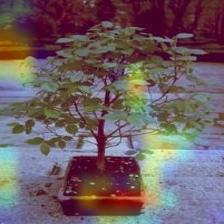

'with respect to neuron corresponding to class-"scorpion"'

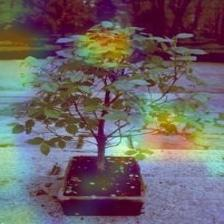

'with respect to neuron corresponding to class-"sunflower"'

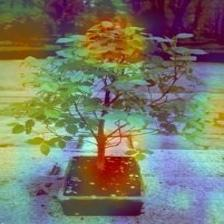

'heatmaps for sunflower class'

'with respect to neuron corresponding to class-"bonsai"'

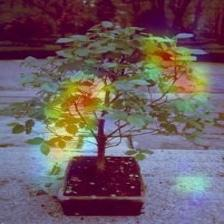

'with respect to neuron corresponding to class-"hawksbill"'

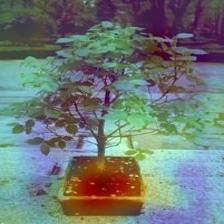

'with respect to neuron corresponding to class-"menorah"'

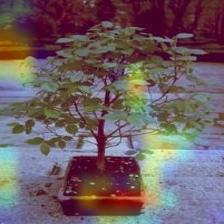

'with respect to neuron corresponding to class-"scorpion"'

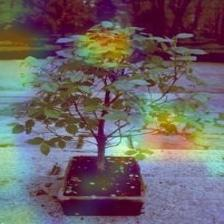

'with respect to neuron corresponding to class-"sunflower"'

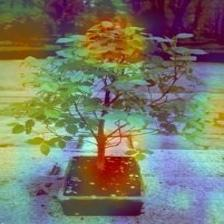

In [40]:
for class_name in class_names:    
    display(f'heatmaps for {class_name} class')
    img_array = get_image("Group_24/train/bonsai/image_0060.jpg")
    last_conv_layer_name = 'block5_conv4'
    heatmaps = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    for i, heatmap in enumerate(heatmaps):
        display(f"{class_names[i]}"')
        save_and_display_gradcam(img, heatmap)